In [24]:
import math

class Location:
    
    """
    Class represents a Mercator projection of the geographical location.
    """
    
    def __init__(self, x, y, tile_size):
        
        """
        Constructs a location using Mercator projection coordinates.
        
        Parameters
        ----------
        
        `x` : `float`
            A horizontal coordinate of the location on the Mercator projection, 
            relative to the top-left corner.
            
        `y` : `float`
            A vertical coordinate of the location on the Mercator projection,
            relative to the top-left corner.
        
        `tile_size` : `int`
            A size of the tile on the Mercator projection.
            
        """
        
        # TODO: validate input arguments
        
        #-----------------------------------------------------------------------
        # PRECALCULATE LOCATION ATTRIBUTES
        #-----------------------------------------------------------------------
        
        # geographical coordinates
        
        lon = x * 360 / tile_size - 180
        lat = math.atan(math.sinh(math.pi * (1 - 2 * y / tile_size)))
        
        # resolution
        
        EARTH_EQUATORIAL_RADIUS = 6378137
        equatorial_circumference = 2 * math.pi * EARTH_EQUATORIAL_RADIUS
        lat_circumference = equatorial_circumference * math.cos(lat)
        resolution = lat_circumference / tile_size
        
        #-----------------------------------------------------------------------
        # STORE INNER ATTRIBUTES
        #-----------------------------------------------------------------------
        
        self.__x          = x
        self.__y          = y
        self.__lat        = math.degrees(lat)
        self.__lon        = lon
        self.__resolution = resolution
        self.__tile_size  = tile_size
    
    @property
    def mercator_coordinates(self):
        """
        Coordinates of the location on the Mercator projection (relative to the 
        top-left corner of the map) in the `(x, y)` format, where `x` is the 
        horizontal coordinate and `y` is the vertical coordinate.
        """
        return (self.__x, self.__y)
    
    @property
    def geo_coordinates(self):
        """
        Geographical coordinates of the location in the `(lat, lon)` format, 
        where `lat` is the latitude and `lon` is the longitude.
        """
        return (self.__lat, self.__lon)
    
    @property
    def tile_size(self):
        """ A size of the tile on the Mercator projection. """
        return self.__tile_size
        
    def map_pixel(self, zoom):
        
        """
        Given a zoom level, calculates and returns pixel coordinates of the 
        location, relative to the entire Mercator projection at the specified 
        zoom level.
        
        Parameters
        ----------

        `zoom` : `int`
            A zoom level.
        
        Returns
        -------

        `(int, int)`
            Pixel coordinates of the location, relative to the top-left corner 
            of the entire map at the given zoom level, in the `(x, y)` format, 
            where `x` is the horizontal coordinate and `y` is the vertical 
            coordinate.
        
        """
        
        # TODO: validate input arguments
        
        scale = 2**zoom
        x = int(self.__x * scale)
        y = int(self.__y * scale)
        return (x, y)
    
    def tile_pixel(self, zoom):
        
        """
        Given a zoom level, calculates and returns pixel coordinates of the 
        location, relative to the tile at the specified zoom level.
        
        Parameters
        ----------

        `zoom` : `int`
            A zoom level.
        
        Returns
        -------

        `(int, int)`
            Pixel coordinates of the location, relative to the top-left corner 
            of the tile at the given zoom level, in the `(x, y)` format, where 
            `x` is the horizontal coordinate and `y` is the vertical coordinate.
        
        """
        
        # TODO: validate input arguments
        
        x, y = self.map_pixel(zoom)
        x %= self.__tile_size
        y %= self.__tile_size
        return (x, y)
    
    def resolution(self, zoom):
        
        """
        Given a zoom level, calculates and returns a pixel resolution at the 
        location for the specified zoom level.
        
        Parameters
        ----------

        `zoom` : `int`
            A zoom level.
        
        Returns
        -------

        `float`
            A resolution at the location for a given zoom level in meters per 
            pixel.
        
        """
        
        # TODO: validate input arguments
        
        scale = 2**zoom
        return self.__resolution / scale
    
    def tile(self, zoom):
        
        """
        Determines and returns a location tile, corresponding to the given zoom 
        level.
        
        Parameters
        ----------

        `zoom` : `int`
            A zoom level.
        
        Returns
        -------

        `Tile`
            A tile that corresponds to the specified zoom level and contains 
            the location.
        
        """
        
        # TODO: validate input arguments
        
        x, y = self.map_pixel(zoom)
        x = int(x / self.__tile_size)
        y = int(y / self.__tile_size)
        return Tile(zoom, x, y, self.__tile_size)
    
    @staticmethod
    def forGeoCoordinates(lat, lon, tile_size):
        
        """
        Creates a new Mercator projection location based on its geographical 
        coordinates.
        
        Parameters
        ----------
        
        `lat` : `float`
            A latitude of the location.
            
        `lon` : `float`
            A longitude of the location.
        
        `tile_size` : `int`
            A size of the tile on the Mercator projection.
        
        Returns
        -------

        `Location`
            A Mercator projection of the location.
        
        """
            
        # Truncating to 0.9999 effectively limits latitude to 89.189. This is
        # about a third of a tile past the edge of the world tile.
        sin_lat = min(max(math.sin(math.radians(lat)), -0.9999), 0.9999)
        
        mercator_x = tile_size * (0.5 + lon / 360)
        mercator_y = tile_size * (0.5 - math.log((1 + sin_lat) / (1 - sin_lat)) / (4 * math.pi))
        
        return Location(mercator_x, mercator_y, tile_size)
    
    @staticmethod
    def forPixelCoordinates(zoom, x, y, tile_size):
        
        """
        Creates a new Mercator projection location based on its pixel 
        coordinates, specific to the given zoom level.
        
        Parameters
        ----------
        
        `zoom` : `int`
            A zoom level.
        
        `x` : `int`
            A horizontal position of the location pixel, relative to the 
            top-left corner of the entire Mercator projection.
        
        `y` : `int`
            A vertical position of the location pixel, relative to the 
            top-left corner of the entire Mercator projection.
        
        `tile_size` : `int`
            A size of the tile on the Mercator projection.
        
        Returns
        -------

        `Location`
            A Mercator projection of the location.
        
        """
        
        scale = 2**zoom
        
        mercator_x = x / scale
        mercator_y = y / scale
        
        return Location(mercator_x, mercator_y, tile_size)
        

In [25]:
import math

class Tile:
    
    """
    Class represents a tile on the map. Tile is identified by the vector 
    `(z, x, y)`, where `z` is the zoom level, `x` is the horizontal position of
    the tile, and `y` is the vertical position of the tile.
    """
    
    def __init__(self, z, x, y, size):
        
        """
        Constructs a map tile.
        
        Parameters
        ----------
        
        `z` : `int`
            A zoom level of the tile.
        
        `x` : `int`
            A horizontal position of the tile, relative to the top-left corner 
            of the Mercator projection.
        
        `y` : `int`
            A vertical position of the tile, relative to the top-left corner 
            of the Mercator projection.
        
        `size` : `int`
            A size of the tile in pixels. Since the tile has a square form, the 
            size is relevant for all sides of the tile.
        
        """
        
        # TODO: validate input arguments
        
        #-----------------------------------------------------------------------
        # PRECALCULATE TILE ATTRIBUTES
        #-----------------------------------------------------------------------
        
        scale = 2**z
        
        # determine pixel coordinates of the tile (top-left corner) on the map
        
        pixel_x = x * size
        pixel_y = y * size
        
        #-----------------------------------------------------------------------
        # STORE INNER ATTRIBUTES
        #-----------------------------------------------------------------------
        
        self.__size    = size
        self.__z       = z
        self.__x       = x
        self.__y       = y
        self.__pixel_x = pixel_x
        self.__pixel_y = pixel_y
        self.__scale   = scale
    
    def __eq__(self, other):
        
        """
        Determines whether `self` equals `other.`
        
        Returns
        -------
        
        `bool`
            `True` if `self` equals `other`, or `False` otherwise.
        
        """
        
        if isinstance(other, Tile):
            return self.__z == other.__z and self.__x == other.__x and self.__y == other.__y
        return False
    
    def __ne__(self, other):
        
        """
        Determines whether `self` does not equal `other.`
        
        Returns
        -------
        
        `bool`
            `True` if `self` does not equal `other`, or `False` otherwise.
        
        """
        
        return not self.__eq__(self, other)
    
    @property
    def vector(self):
        """
        A tile vector in the `(z, x, y)` format, where `z` is the zoom level, 
        `x` is the horizontal position of the tile, and `y` is the vertical 
        position of the tile.
        """
        return (self.__z, self.__x, self.__y)
    
    @property
    def size(self):
        """
        A size of the tile side in pixels.
        """
        return self.__size
    
    def locate(self, x, y):
        
        """
        Given pixel coordinates, relative to the top-left corner of the tile, 
        determines and returns a location, corresponding to this pixel.
        
        Parameters
        ----------

        `x` : `int`
            A horizontal position of the pixel, relative to the top-left corner 
            of the tile.
        
        `y` : `int`
            A vertical position of the pixel, relative to the top-left corner 
            of the tile.

        Returns
        -------

        `Location`
            A location that corresponds to the specified pixel.
        
        """
        
        # TODO: validate input arguments
        
        # rebase pixel coordinates from tile to map
        
        x = self.__pixel_x + x
        y = self.__pixel_y + y
        
        return Location.forPixelCoordinates(self.__z, x, y, self.__size)
    

In [26]:
import os
import sys
import math
import wget

from PIL import Image, ImageDraw
from urllib.error import HTTPError

STAMEN_TERRAIN_BACKGROUND = "https://stamen-tiles-a.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}.png"
DATA_DIR = "../data/maps/terrain"

class Map:
    
    """
    Class represents a map using Mercator projection.
    """
    
    def __init__(self, url_template=STAMEN_TERRAIN_BACKGROUND, data_dir=DATA_DIR, max_zoom=17):
        
        """
        Constructs a new map.
        
        Parameters
        ----------

        `url_template` : `str` (optional)
            A URL template of the tile service. It must contain following 
            placeholders:
                
                * `{z}` - for zoom level.
                * `{x}` - for tile horizontal coordinate.
                * `{y}` - for tile vertical coordinate.
            
            By default, the Stamen service (terrain background) is used.
            
        `data_dir` : `str` (optional)
            A path to the local directory where tile images are cached.
        
        `max_zoom` : `int` (optional)
            A maximum allowed zoom for the map. Default value is `17`.
        
        """
        
        # TODO: validate input arguments
        
        self.__url_template = url_template
        self.__data_dir     = data_dir
        self.__max_zoom     = max_zoom
        
        # determine the tile size by getting one tile sample
        
        self.__tile_size = 256 # default tile size
        with self.__load_tile(0, 0, 0) as img:
            width, _ = img.size
            self.__tile_size = width
    
    @property
    def tile_size(self):
        """
        The size of the tile. Since the tile has a square form, the size is 
        relevant for all sides of the tile.
        """
        return self.__tile_size
    
    @property
    def max_zoom(self):
        """ The maximum zoom level allowed by the map. """
        return self.__max_zoom
    
    def find(self, lat, lon):
        
        """
        Finds and returns a location, corresponding to the given geographical 
        coordinates.
        
        Parameters
        ----------
        
        `lat` : `float`
            A latitude of the location.
            
        `lon` : `float`
            A longitude of the location.
            
        Returns
        -------
        
        `Location`
            A location for given latitude and longitude.
        
        """
        
        return Location.forGeoCoordinates(lat, lon, self.__tile_size)
    
    
    def render(self, zoom, location, color=(255,0,0,255)):
        
        """
        Renders a pixel on the tile that corresponds to a given location.
        
        Parameters
        ----------

        `zoom` : `int`
            A zoom level.
        
        `location` : `Location`
            A location to render.
            
        `color` : `(int, int, int, int)` (optional)
            A color to use for the location on the map in the `(r, g, b, a)` 
            format, where `r`, `g` and `b` are intensities of red, green and 
            blue channels respectively, and `a` is the intensity of the alpha 
            channel (opacity). The default color is red with 100% opacity (
            `(255, 0, 0, 255)`).
        
        """
        
        # TODO: validate input arguments
        
        tile = location.tile(zoom)
        pixel = location.tile_pixel(zoom)
        
        r = 1
        top_left = (pixel[0]-r, pixel[1]-r)
        bottom_right = (pixel[0]+r, pixel[1]+r)
        pos = [top_left, bottom_right]
        
        with self.load_tile(tile) as img:
            draw = ImageDraw.Draw(img)
            draw.ellipse(pos, fill=color)
            return img
        
    def load_tile(self, tile):
        
        """
        Loads an image of for the given tile from the tile service.
        
        Parameters
        ----------
        
        `tile` : `Tile`
            A tile to load an image for.
            
        Returns
        -------
        
        `PIL.Image.Image`
            An image of the tile in the `RGBA` mode.
            
        """
        
        vector = tile.vector
        with self.__load_tile(vector[0], vector[1], vector[2]) as img:
            return img.convert("RGBA")
    
    def __load_tile(self, z, x, y):
        
        # TODO: validate input arguments
        
        sz = str(z)
        sx = str(x)
        sy = str(y)
        
        # path to tile
        path = os.path.join(self.__data_dir, sz, sx);
        if not os.path.exists(path):
            os.makedirs(path)
        path += "/" + sy + ".png"
        
        # download tile if it does not exist
        if not os.path.exists(path):
            url = self.__url_template.format(z=sz, x=sx, y=sy)
            try:
                wget.download(url, path)
            except HTTPError as e:
                print(f"Could not download the tile: tile=({z}, {x}, {y}), error='{e}'", file=sys.stderr)
        
        return Image.open(path)
        

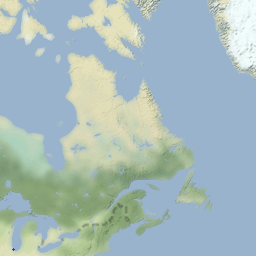

Geographical coordinate: (41.85000000000001, -87.64999999999999)
Mercator coordinate: (65.67111111111112, 95.17492654697409)
Map pixel coordinate: (525, 761)
Tile pixel coordinate: (13, 249)
Resolution: 14575.996946727291 m/pixel
Tile: (3, 2, 2)


In [27]:
from IPython.display import display

# London
# lat = 51.507222 # latitude
# lon = -0.127500 # longitude
# zoom = 1        # zoom level

# Chicago
lat = 41.85     # latitude
lon = -87.65    # longitude
zoom = 3        # zoom level

map = Map()
location = map.find(lat, lon)
tile = location.tile(zoom)

with map.render(zoom, location) as img:
    display(img)

print(f"Geographical coordinate: {location.geo_coordinates}")
print(f"Mercator coordinate: {location.mercator_coordinates}")
print(f"Map pixel coordinate: {location.map_pixel(zoom)}")
print(f"Tile pixel coordinate: {location.tile_pixel(zoom)}")
print(f"Resolution: {location.resolution(zoom)} m/pixel")
print(f"Tile: {tile.vector}")


In [31]:
import math
from PIL import Image, ImageDraw

class GreatCirclePath:
    
    """
    Class represents a great-circle path. Such a path yields the shortest 
    distance between two points on the globe.
    """
    
    def __init__(self, origin, destination, map=Map()):
        
        """
        Constructs the great-circle path from the origin point to the 
        destination point.
        
        Parameters
        ----------

        `origin` : `Location`
            A location of the path origin point.
            
        `destination` : `Location`
            A location of the path destination point.
        
        `map` : `Map` (optional)
            A map used for the visualization of the path. If the map is not 
            provided, then the default map will be used.
        
        """
        
        # TODO: validate input arguments
        
        #-----------------------------------------------------------------------
        # PRECALCULATE PATH PARAMETERS
        #-----------------------------------------------------------------------
        
        origin_geo      = origin.geo_coordinates
        destination_geo = destination.geo_coordinates
        
        lat1 = math.radians(origin_geo[0])
        lon1 = math.radians(origin_geo[1])
        lat2 = math.radians(destination_geo[0])
        lon2 = math.radians(destination_geo[1])
        
        # calculate longitude component of the path
        
        lon12 = lon2 - lon1
        lon12 = math.atan2(math.sin(lon12), math.cos(lon12))
        
        # calculate azimuths at origin and destination
        
        a1 = math.atan2(math.cos(lat2) * math.sin(lon12), math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon12))
        a2 = math.atan2(math.cos(lat1) * math.sin(lon12), -math.cos(lat2) * math.sin(lat1) + math.sin(lat2) * math.cos(lat1) * math.cos(lon12))
        
        # calculate central angle between origin and destination
        
        o12 = math.atan2(math.sqrt((math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon12))**2 + (math.cos(lat2) * math.sin(lon12))**2), math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon12))
        
        # calculate the length of the path along the great circle
        
        R = 6371008.8 # average Earth radius
        d = R * o12
        
        # calculate the azimuth at the point at which the great circle crosses 
        # the equator in the northward direction
        
        a0 = math.atan2(math.sin(a1) * math.cos(lat1), math.sqrt(math.cos(a1)**2 + math.sin(a1)**2 * math.sin(lat1)**2))
        
        # calculate central angle between origin and the point at which the 
        # great circle crosses the equator
        
        o01 = math.atan2(math.tan(lat1), math.cos(a1))
        
        # calculate central angle between destination and the point at which 
        # the great circle crosses the equator
        
        o02 = o01 + o12
        
        # calculate the longitude of a point at which the great circle crosses 
        # the equator
        
        lon01 = math.atan2(math.sin(a0) * math.sin(o01), math.cos(o01))
        lon0  = lon1 - lon01
        
        #-----------------------------------------------------------------------
        # PREPARE MAP
        #-----------------------------------------------------------------------
        
        # determine the maximum zoom level at which both, origin and 
        # destination are visible
        
        zoom = map.max_zoom
        while True:
            origin_tile      = origin.tile(zoom)
            destination_tile = destination.tile(zoom)
            if origin_tile == destination_tile:
                break
            zoom -= 1
        
        #-----------------------------------------------------------------------
        # STORE INNER PARAMETERS
        #-----------------------------------------------------------------------
        
        self.__origin              = (origin_geo[0], origin_geo[1], math.degrees(a1))
        self.__destination         = (destination_geo[0], destination_geo[1], math.degrees(a2))
        self.__length              = d
        self.__angle               = math.degrees(o12)
        self.__origin_angle        = o01
        self.__destination_angle   = o02
        self.__equatorial_lon      = lon0
        self.__equatorial_azimuth  = a0
        self.__map                 = map
        self.__zoom                = zoom
    
    @property
    def origin(self):
        """
        Navigation vector at the path origin in the `(lat, lon, azimuth)` 
        format.
        """
        return self.__origin
    
    @property
    def destination(self):
        """
        Navigation vector at the path destination in the `(lat, lon, azimuth)` 
        format.
        """
        return self.__destination
    
    @property
    def length(self):
        """ The total length of the path in meters. """
        return self.__length
    
    @property
    def angle(self):
        """
        The central angle (in degrees) between origin and destination points of 
        the path.
        """
        return self.__angle
    
    def waypoint(self, progress):
        
        """
        Given the progress along the path, calculates the navigation vector 
        `(lat, lon, azimuth)`, corresponding to this path.
        
        Parameters
        ----------

        `progress` : `float`
            A progress along the path in percent (`[0..1]`).

        Returns
        -------

        `(float, float, float)`
            Navigation vector in the `(lat, lon, azimuth)` format.
        
        """
        
        # TODO: validate input arguments
        
        o01  = self.__origin_angle
        o02  = self.__destination_angle
        a0   = self.__equatorial_azimuth
        lon0 = self.__equatorial_lon
        
        # calculate the central angle between the progress point and the point 
        # at which the great circle crosses the equator
        
        o = o01 + (o02 - o01) * progress
        
        # calculate the position and azimuth at the progress point
        
        lat = math.atan2(math.cos(a0) * math.sin(o), math.sqrt(math.cos(o)**2 + math.sin(a0)**2 * math.sin(o)**2))
        lon = math.atan2(math.sin(a0) * math.sin(o), math.cos(o)) + lon0
        a   = math.atan2(math.tan(a0), math.cos(o))
        
        # normalize longitude
        
        lon = math.atan2(math.sin(lon), math.cos(lon))
        
        return (math.degrees(lat), math.degrees(lon), math.degrees(a))
    
    def navigate(self, waypoints=50):
        
        """
        Calculates and returns waypoints along the path.
        
        Parameters
        ----------
        
        `waypoints` : `int` (optional)
            A number of waypoints to calculate. Please note that the origin and 
            the destination are not counted. The default value is `50`.
        
        Returns
        -------
        
        `list`
            A list of waypoint vectors in the `(lat, lon, azimuth)` format. 
            Please note, the origin is added to the head of the list and the 
            destination is added to the tail of the list.
        
        """
        
        # TODO: validate input arguments
        
        path = []
        path.append(self.__origin)
        
        step = 1 / (waypoints + 1)
        linspace = [(i + 1) * step for i in range(waypoints)]
        for i in linspace:
            path.append(self.waypoint(i))
        
        path.append(self.__destination)
        return path
    
    def visualize(self, waypoints=50, color=(255,0,0,255)):
        
        """
        Visualizes the path on the map.
        
        Parameters
        ----------
        
        `waypoints` : `int` (optional)
            A number of waypoints between the origin and the destination to use 
            to visualize the path. The default value is `50`.
            
        `color` : `(int, int, int, int)` (optional)
            A color to use for the path on the map in the `(r, g, b, a)` format,
            where `r`, `g` and `b` are intensities of red, green and blue 
            channels respectively, and `a` is the intensity of the alpha 
            channel (opacity). The default color is red with 100% opacity (
            `(255, 0, 0, 255)`).
        
        Returns
        -------
        
        `PIL.Image.Image`
            A visualized image in `RGBA` mode.
        
        """
        
        # TODO: validate input arguments
        
        # we pre-calculated zoom in the constructor at which both, origin and 
        # destination are visible
        
        location = self.__map.find(self.__origin[0], self.__origin[1])
        tile     = location.tile(self.__zoom)
        img      = self.__map.load_tile(tile)
        draw     = ImageDraw.Draw(img)
        vectors  = self.navigate(waypoints)
        
        # draw path segments between waypoints
        
        v0 = None
        line = []
        
        for v in vectors:
            
            # a special case when the path crosses from the Western Hemisphere
            # into the Eastern Hemisphere
            
            if v0 is not None and v[1] > 0 and v0[1] < 0 and v0[2] < 0 and v0[2] > -180:
                
                location = self.__map.find(v[0], v[1] - 360)
                x, y = location.tile_pixel(self.__zoom)
                line.append((x, y))
                draw.line(line, fill=color)
                
                line = []
                location = self.__map.find(v0[0], 360 + v0[1])
                x, y = location.tile_pixel(self.__zoom)
                line.append((x, y))
            
            # a special case when the path crosses from the Eastern Hemisphere
            # into the Western Hemisphere
            
            if v0 is not None and v0[1] > 0 and v[1] < 0 and v0[2] > 0 and v0[2] < 180:
                
                location = self.__map.find(v[0], 360 + v[1])
                x, y = location.tile_pixel(self.__zoom)
                line.append((x, y))
                draw.line(line, fill=color)
                
                line = []
                location = self.__map.find(v0[0], v0[1] - 360)
                x, y = location.tile_pixel(self.__zoom)
                line.append((x, y))
            
            # normal case
            
            location = self.__map.find(v[0], v[1])
            x, y = location.tile_pixel(self.__zoom)
            line.append((x, y))
            v0 = v
        
        # TODO: try to use rhumb lines between waypoints
        
        draw.line(line, fill=color)
        return img
        



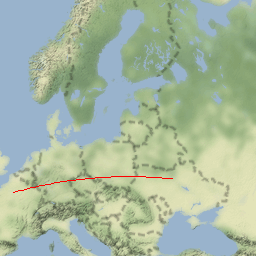

midpoint: φ = 50.485528537179306, λ = 16.12534642048552, α = -94.98726542344546
length: 2017590 m


In [33]:
from IPython.display import Image as DisplayImage, display

# Valparaiso
# lat1 = -33
# lon1 = -71.6

# Shanghai
# lat2 = 31.4
# lon2 = 121.8

# Seattle
# lat1 = 47.6130071
# lon1 = -122.4121034

# Cairo
# lat1 = 30.0594838
# lon1 = 31.2234451

# Kyiv
lat1 = 50.4019514
lon1 = 30.3926108

# London
# lat2 = 51.507222
# lon2 = -0.127500

# Paris
lat2 = 48.8588495
lon2 = 2.3120158

map = Map()
origin = map.find(lat1, lon1)
destination = map.find(lat2, lon2)

path = GreatCirclePath(origin, destination)
wp = path.waypoint(0.5)

with path.visualize() as img:
    display(img)

print(f"midpoint: φ = {wp[0]}, λ = {wp[1]}, α = {wp[2]}")
print(f"length: {round(path.length)} m")

In [11]:
import sys
import time
import random

zoom = 8
tiles = 2**zoom
total = 2**(zoom + 1) - 1

map = Map()
for x in range(tiles):
    for y in range(tiles):
        #time.sleep(random.random())
        map._Map__get_tile(zoom, x, y)
        done = int((x * tiles + y + 1) / total * 100)
        sys.stdout.write(f" ({zoom}, {x}, {y}) {done}%            \r")
